In [146]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [147]:
from proj1_helpers import *
from implementations import *

# Load the training data into feature matrix, class labels, and event ids:

In [148]:
DATA_TRAIN_PATH = '../data/train.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

### Simple data description 
- all variables are floating point, except PRI_jet_num which is integer
- variables prefixed with PRI (for PRImitives) are “raw” quantities about the bunch collision as measured by the detector.
- variables prefixed with DER (for DERived) are quantities computed from the primitive features, which were selected by the physicists of ATLAS.
- it can happen that for some entries some variables are meaningless or cannot be computed; in this case, their value is −999.0, which is outside the normal range of all variables.

In [149]:
print('y shape = ' + str(y.shape) + '\ntX shape =' + str(tX.shape) + '\nids shape = ' + str(ids.shape))

y shape = (250000,)
tX shape =(250000, 30)
ids shape = (250000,)


Description of the data:
- `y` (N) is composed of the labels (-1 or 1) of all the samples.  
- `tX` (N x F) is composed of the values of the features (F) for all samples (N)  
- `ids` (N) is composed of all the index (100000-349999) of the samples (N)  
  
Moreover, the number of features is 30 (F=30) and the number of samples is 250'000 (N=250'000). Non recorded data has value `-999`. 

# Exploratory analysis

Feature 2:


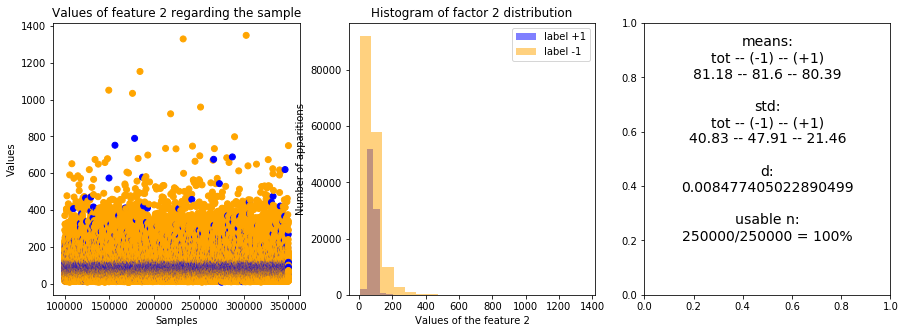

Feature 6:


C:\Users\Christelle\Anaconda3\envs\ml\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Christelle\Anaconda3\envs\ml\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


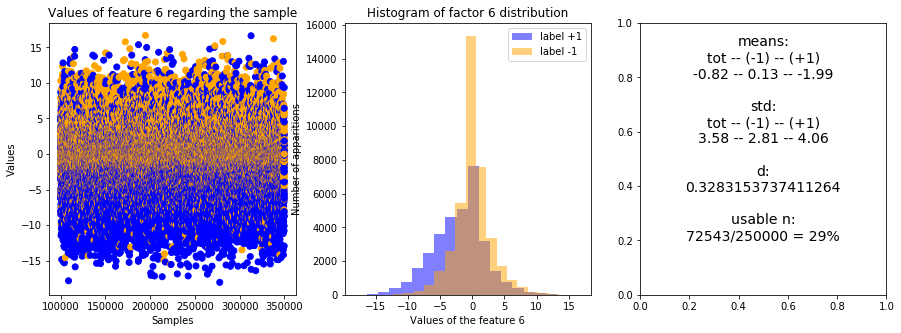

Feature 10:


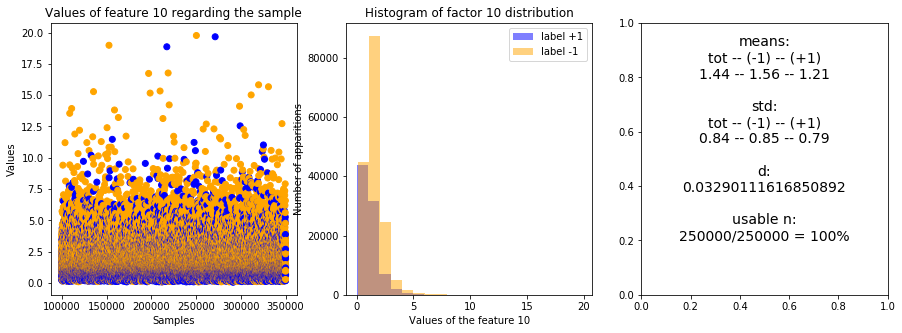

Feature 15:


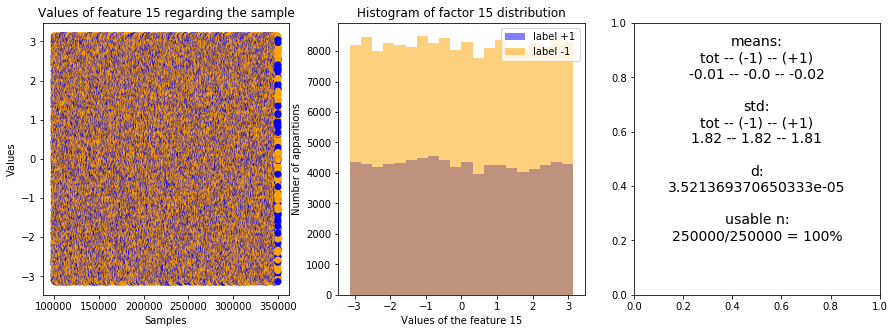

Feature 20:


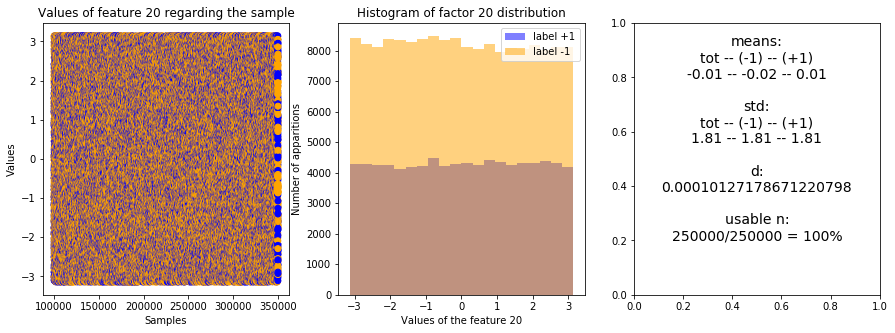

Feature 27:


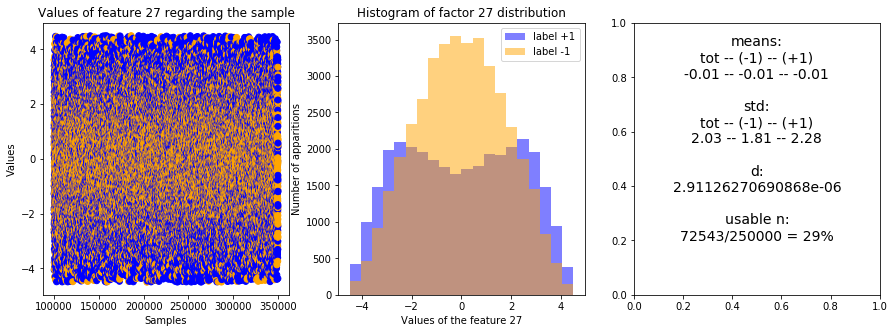

In [5]:
tX0 = np.where(tX==-999, np.nan,tX)

for f in [2, 6, 10, 15, 20, 27]:
    plot_feature(ids, tX0, y, f)

# Data pre-processing 

As we can see when plotting all the features in the exploratory analysis, some distributions are right-skewed, so that we can apply a log transformation to these features namely columns : `[0, 2, 5, 9, 13, 16, 19, 21, 23, 26, 29]`.

In [150]:
tX = log_transformation(tX)

# Feature processing

Then with this data, we separate the data points based on the categorical data: jet. We keep three matrices with `jet = 0`, `jet = 1` and `jet > 2`. We will futher train separately our models on each of these sub-matrices and have separated, learning rates, penalities or polynomial degrees for each. 

We still keep the whole data matrix to do the same treatments and generate whole weight matrices as a comparison. 

In [151]:
idx0, y_jet0, tX_jet0, idx1, y_jet1, tX_jet1, idx2, y_jet2, tX_jet2 = separate_jet(y, tX)

For each dataset, we clean them by setting all missing values `-999` to `NaN`, then when for a feature the ratio of missing values reaches a threshold, we remove the whole feature from the dataset. The remaining missing data are replaced by the median value in the column (we also tried to replace the missing data by the mean value of the feature or a gaussian distribution. Then we standarize the data. 

In [152]:
missingness_cutoff = 0.95

In [153]:
tX, rmX = missingness_filter(tX, missingness_cutoff)

In [154]:
tX, mtX = impute_median_train(tX)

In [155]:
tX_jet0, rmX_jet0 = missingness_filter(tX_jet0, missingness_cutoff)
tX_jet1, rmX_jet1 = missingness_filter(tX_jet1, missingness_cutoff)
tX_jet2, rmX_jet2 = missingness_filter(tX_jet2, missingness_cutoff)
tX_jet0, median_jet0 = impute_median_train(tX_jet0)
tX_jet1, median_jet1 = impute_median_train(tX_jet1)
tX_jet2, median_jet2 = impute_median_train(tX_jet2)

In [156]:
print("tX shape={tXs}\ntX_jet0 shape={tX0s}\ntX_jet1 shape={tX1s}\ntX_jet2+ shape={tX2s}".format(
    tXs=tX.shape, tX0s=tX_jet0.shape, tX1s=tX_jet1.shape, tX2s=tX_jet2.shape))

print("\nremoved columns for :\ntX={rmX}\ntX_jet0={rmX0}\ntX_jet1={rmX1}\ntX_jet2+={rmX2}".format(
    rmX=rmX, rmX0=rmX_jet0, rmX1=rmX_jet1, rmX2=rmX_jet2))

tX shape=(250000, 30)
tX_jet0 shape=(99913, 18)
tX_jet1 shape=(77544, 22)
tX_jet2+ shape=(72543, 29)

removed columns for :
tX=[]
tX_jet0=[ 4  5  6 12 22 23 24 25 26 27 28]
tX_jet1=[ 4  5  6 12 25 26 27]
tX_jet2+=[]


## Least squares

### Full dataset

In [12]:
tX1,_,_ = standardize_train(tX.copy())

In [13]:
(w_ls, loss_ls) = least_squares(y, tX1)

print("w* ={w}\n\nmse={loss}".format(w=w_ls, loss=loss_ls))

w* =[ 6.92869792e-02 -2.27600544e-01 -2.45039426e-01 -2.66051358e-02
  2.85085174e-01 -2.28837880e-01 -2.36463756e-02  2.61870483e-01
 -1.31856784e-02 -3.47306217e-02  7.53604150e-02  1.02857848e-01
  6.83104415e-02  3.57841348e-01 -7.84631792e-04 -1.52397042e-03
  5.17247923e-02 -1.06442091e-03  2.68356283e-03  5.23023977e-03
  1.31383306e-03 -1.03975577e-02 -1.21424046e-01  8.62918795e-02
 -3.12824605e-05  2.51367468e-04  5.90276099e-02  1.25391874e-03
 -7.77160024e-04  1.59764600e-01]

mse=0.38914743181408895


### Jet sub-datasets

In [14]:
for index_jet, (yi, txi) in enumerate(zip([y_jet0, y_jet1, y_jet2], [tX_jet0, tX_jet1, tX_jet2])):
    tx1, _, _ = standardize_train(txi.copy())
    (w_ls, loss_ls) = least_squares(yi, tx1)
    print("w_jet{jet}* = {w}\nmse = {loss}\n\n".format(
    jet=index_jet, w=w_ls, loss=loss_ls))

w_jet0* = [-1.74970402e-02 -6.94172527e-02 -4.39453932e-01  5.63282196e+02
  4.02890741e-01 -5.63279044e+02 -8.83365301e-01  6.74340117e-01
  1.84022626e-02  1.51810216e+00  1.10929682e-03 -4.43671545e-04
  1.21783187e-01  4.97697352e-03  5.47237967e-04 -1.18858719e-01
 -5.41881505e-03  2.19920698e-02]
mse = 0.3850451256746361


w_jet1* = [ 1.12241953e-01 -2.46895184e-01 -2.27161637e-01 -1.18993008e-01
  1.80035809e-01  4.61359370e-02 -2.09064469e-01  1.04499377e-01
  1.29384652e-01  4.35296057e-01  3.83881693e-03 -3.55670901e-03
  1.20816561e-01 -8.25578943e-03  1.24287339e-03  6.02612578e-02
  3.53113414e-03 -2.31815245e-02 -9.00226451e+02 -1.16016017e-03
 -2.88383782e-03  9.00488750e+02]
mse = 0.4107496058509512


w_jet2* = [ 1.79464305e-01 -1.79022571e-01 -4.36985800e-02  1.19086507e-03
  3.04579817e-01 -1.87240722e-01 -3.63350480e-02 -7.68112951e-03
 -2.96505619e-02 -4.51397545e-01  7.29645384e-02  1.05489728e-01
  1.29167673e-01  3.12031140e-01 -4.82935014e-03 -5.68384847e-04
  9

## Least squares with Gradient Descent

### Full dataset

In [18]:
#define parameters
initial_w = np.zeros(tX.shape[1])
max_iters = 100
gammas = np.logspace(-6, 0, 20)

losses_gd = np.empty(len(gammas))
ws_gd = np.empty((len(gammas), len(initial_w)))

tX1,_,_ = standardize_train(tX)

for idx, gamma in enumerate(gammas):
    (w, loss) = least_squares_GD(y, tX1, initial_w, max_iters, gamma)
    losses_gd[idx] = loss
    ws_gd[idx, :]=w

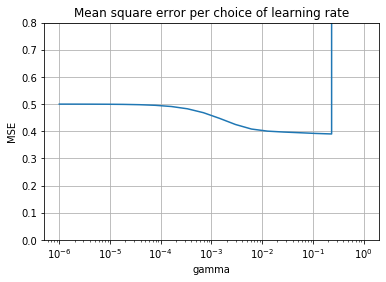

In [19]:
#plot the losses per gamma
fig, ax = plt.subplots()
ax.semilogx(gammas, losses_gd)

ax.set(xlabel='gamma', ylabel='MSE',
       title='Mean square error per choice of learning rate')
ax.grid()
ax.set_ylim([0, 0.8])
plt.show()

In [20]:
idx = np.nanargmin(losses_gd)

w_gd = ws_gd[idx]
gamma_gd = gammas[idx]

print("w* ={w}\n\nmse={loss}\n\ngamma={gamma}".format(
    w=w_gd, loss=losses_gd[idx], gamma=gamma_gd))

w* =[ 6.72659737e-02 -2.29301146e-01 -1.76168279e-01  8.16762431e-03
  1.75810145e-01 -1.22009037e-01 -3.13291611e-02  1.98734615e-01
 -2.19339745e-02  7.73832794e-02  4.54831649e-02  1.08085787e-01
  7.44148975e-02  2.79844657e-01 -8.98916044e-04 -1.58680536e-03
  2.12269392e-02 -9.74585933e-04  2.83749408e-03 -3.07230712e-03
  1.27973548e-03 -1.16165729e-02 -8.88806888e-02  2.96779062e-02
 -7.54411860e-05  2.85015077e-04  1.46649187e-02  1.27415068e-03
 -7.99091016e-04  4.03883503e-02]

mse=0.3901537155828724

gamma=0.23357214690901212


### Jet sub-datasets

In [21]:
#define parameters
max_iters = 100
gammas = np.logspace(-6, 0, 10)

for index_jet, (yi, txi) in enumerate(zip([y_jet0, y_jet1, y_jet2], [tX_jet0.copy(), tX_jet1.copy(), tX_jet2.copy()])):
    tx1, _, _ = standardize_train(txi.copy())
    initial_w = np.zeros(tx1.shape[1])
    losses_gd = np.empty(len(gammas))
    ws_gd = np.empty((len(gammas), len(initial_w)))

    for index_g, gamma in enumerate(gammas):
        (w, loss) = least_squares_GD(yi, tx1, initial_w, max_iters, gamma)
        losses_gd[index_g] = loss
        ws_gd[index_g, :]=w
        
    idx = np.nanargmin(losses_gd)
    w_gd = ws_gd[idx]
    gamma_gd = gammas[idx]
    print("w_jet{jet}* = {w}\nmse = {loss}\ngamma = {gamma}\n\n".format(
    jet=index_jet, w=w_gd, loss=losses_gd[idx], gamma=gamma_gd))

w_jet0* = [-1.74881338e-02 -1.07316309e-01 -3.37871727e-01 -1.31179058e-03
  3.11908909e-01 -1.31182665e-03  2.30654684e-01  1.01466101e-01
  2.71839179e-02  3.02028907e-01  2.08206015e-04 -9.57595948e-04
 -1.93876936e-01  5.76722746e-03  5.05047291e-04 -1.15697466e-01
 -5.37883426e-03  2.30454646e-02]
mse = 0.38739657931688903
gamma = 0.21544346900318823
w_jet1* = [ 0.09709701 -0.2463504  -0.16453206 -0.12461518  0.1381752   0.04726824
  0.09056652  0.02475729  0.13650278  0.25169333  0.00372348 -0.0037362
  0.04176547 -0.00811408  0.00123296  0.05553858  0.00349964 -0.02386752
  0.03430592 -0.00114232 -0.00277755  0.03430604]
mse = 0.4114924908060583
gamma = 0.21544346900318823
w_jet2* = [ 0.16602994 -0.1790747  -0.00140282  0.04540912  0.14675795 -0.0183805
 -0.04070351 -0.03578692 -0.04446335 -0.09401762  0.01767612  0.10998299
  0.1352933   0.18113416 -0.00469803 -0.00062645  0.03564574 -0.00541664
  0.00310369  0.04645935  0.00632582 -0.16000594  0.09542604  0.00344447
  0.005521

## Least squares with Stochastic Gradient Descent

### Full dataset

In [22]:
initial_w = np.zeros(tX.shape[1])
max_iters = 100
gammas = np.logspace(-6, 0, 20)

losses_sgd = np.empty(len(gammas))
ws_sgd = np.empty((len(gammas), len(initial_w)))

tX1, _, _ = standardize_train(tX.copy())

for idx, gamma in enumerate(gammas):
    (w, loss) = least_squares_SGD(y, tX1, initial_w, max_iters, gamma)
    losses_sgd[idx] = loss
    ws_sgd[idx,:] = w

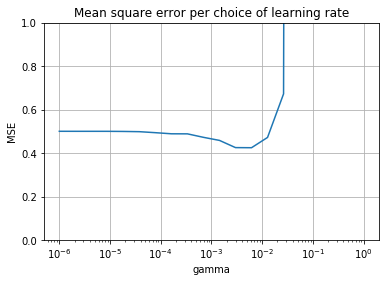

In [23]:
#plot the losses per gamma used
fig, ax = plt.subplots()
ax.semilogx(gammas, losses_sgd)

ax.set(xlabel='gamma', ylabel='MSE',
       title='Mean square error per choice of learning rate')
ax.grid()
ax.set_ylim([0, 1])
plt.show()

In [24]:
idx = np.nanargmin(losses_sgd)

w_sgd = ws_sgd[idx]
gamma_sgd = gammas[idx]

print("w*={w}\n\nmse={loss}\n\ngamma={gamma}".format(
    w=w_sgd, loss=losses_sgd[idx], gamma=gamma_sgd ))

w*=[ 0.05616795 -0.042248    0.0451998   0.01369566  0.08420608  0.04551237
 -0.03876723  0.03062081 -0.03237296  0.028792   -0.09276359  0.0835462
  0.10379549  0.09945338 -0.0154348  -0.05761006 -0.03402532 -0.03631335
 -0.03071642 -0.00939326  0.0039578   0.0879781   0.01833514  0.01739283
  0.03041496 -0.04847715 -0.03592401 -0.01711584  0.00652368  0.01818432]

mse=0.4243940374529844

gamma=0.00615848211066026


### Jet sub-datasets

In [25]:
#define parameters
max_iters = 100
gammas = np.logspace(-6, 0, 10)

for index_jet, (yi, txi) in enumerate(zip([y_jet0, y_jet1, y_jet2], [tX_jet0, tX_jet1, tX_jet2])):
    tx1, _, _ = standardize_train(txi.copy())
    initial_w = np.zeros(tx1.shape[1])
    losses_gd = np.empty(len(gammas))
    ws_gd = np.empty((len(gammas), len(initial_w)))

    for index_g, gamma in enumerate(gammas):
        (w, loss) = least_squares_SGD(yi, tx1, initial_w, max_iters, gamma)
        losses_gd[index_g] = loss
        ws_gd[index_g, :]=w
        
    idx = np.nanargmin(losses_gd)
    w_gd = ws_gd[idx]
    gamma_gd = gammas[idx]
    print("w_jet{jet}* = {w}\nmse = {loss}\ngamma = {gamma}\n\n".format(
    jet=index_jet, w=w_gd, loss=losses_gd[idx], gamma=gamma_gd))

w_jet0* = [ 0.04390627 -0.15773433  0.00218562 -0.05951757  0.10411228 -0.05951757
 -0.0014221  -0.09435064  0.04587984  0.0680112  -0.00989339  0.03202793
 -0.07334064 -0.06506531 -0.0905897  -0.09460105 -0.011082   -0.04617535]
mse = 0.4382353717196312
gamma = 0.01
w_jet1* = [ 0.02760512 -0.04659972  0.00801378  0.03371731  0.03258029  0.013986
  0.01849132 -0.04475942  0.03617361  0.03514159 -0.01783474 -0.01482629
 -0.04142139  0.01795739 -0.00150515  0.01563471 -0.00490493  0.01927513
  0.02797487  0.00457092 -0.00039837  0.02797487]
mse = 0.4501937630478846
gamma = 0.002154434690031882
w_jet2* = [ 8.99800441e-02 -2.03360880e-01  2.56065302e-02  5.00103736e-02
  1.48079374e-01  1.22717134e-01 -9.52186153e-02  9.67793547e-03
 -4.42105082e-02  1.14504546e-02  1.62263603e-02  6.24442256e-02
  9.22673775e-02  6.77280156e-02  5.05286922e-02  8.32638277e-02
 -6.01274107e-02 -8.82255830e-02 -6.87767880e-03  5.60918992e-03
  3.43258038e-02 -1.61438094e-02  3.97088893e-02  9.09601905e-04
 

## Ridge regression

For ridge regression, we have two parameters to optimize, the lambda (penality) and degree (complexity). To do so, we use a cross validation that optimizes both at the same time. 

Then a biais and variance decomposition is used to visualize if the methods tend to underfit or overfit. 

### Full dataset

#### Cross-validation hyperparameter selection

In [121]:
w_interaction = False

In [13]:
seed = 1
degree_ri = 1
k_fold = 4
lambdas = np.logspace(-20, -8, 13)
degrees = range(6, 15)

k_indices = build_k_indices(y, k_fold, seed)

rmse_tr_ri, rmse_te_ri, acc_measures = cross_validation_wAcc(y, tX, k_indices, k_fold, degrees, 
                                          lambdas , ml_function = 'ri', max_iters = 100, 
                                          gamma = 0.05, verbose = True, interaction=w_interaction)

Finished preparing data for cross-validation 

Completed degree 9/9
 Completed lambda 1/13
Completed degree 9/9
 Completed lambda 2/13
Completed degree 9/9
 Completed lambda 3/13
Completed degree 9/9
 Completed lambda 4/13
Completed degree 9/9
 Completed lambda 5/13
Completed degree 9/9
 Completed lambda 6/13
Completed degree 9/9
 Completed lambda 7/13
Completed degree 9/9
 Completed lambda 8/13
Completed degree 9/9
 Completed lambda 9/13
Completed degree 9/9
 Completed lambda 10/13
Completed degree 9/9
 Completed lambda 11/13
Completed degree 9/9
 Completed lambda 12/13
Completed degree 9/9
 Completed lambda 13/13


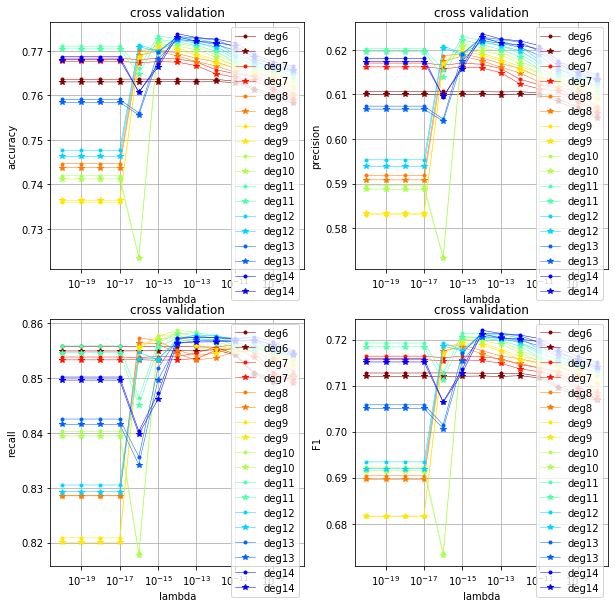

In [14]:
vis_cv_acc(degrees,lambdas,acc_measures)

In [15]:
idx = np.unravel_index(np.nanargmax(acc_measures["acc_te"]), acc_measures["acc_te"].shape)
lambda_ri = lambdas[idx[0]]
degree_ri = degrees[idx[1]]

print("lambda*={lambda_}\n\ndegree*={degree}\n\nrmse train={rmse_tr}\n\nrmse test={rmse_te}\n\nacc train={acc_tr}\n\nacc test={acc_te}".format(
    lambda_=lambda_ri, degree=degree_ri, rmse_tr=rmse_tr_ri[idx], rmse_te=rmse_te_ri[idx],acc_tr=acc_measures["acc_tr"][idx], acc_te=acc_measures["acc_te"][idx]))

lambda*=1e-14

degree*=14

rmse train=0.32070661141411044

rmse test=1.7297185388782197e+28

acc train=0.773828

acc test=0.773116


In [16]:
w_ri, loss_ri, acc_measures_ri, data_meas_ri = build_final_model(y, tX, degree_ri,
                                                      lambda_ri, ml_function = 'ri', interaction = w_interaction)

In [17]:
print(acc_measures_ri)

{'acc': 0.77362, 'pre': 0.6233578872331036, 'rec': 0.8574363523877339, 'f1': 0.721895991705282}


### Jet sub-datasets

#### Cross-validation for hyperparameter selection

Finished preparing data for cross-validation 

Completed degree 7/7
 Completed lambda 1/10
Completed degree 7/7
 Completed lambda 2/10
Completed degree 7/7
 Completed lambda 3/10
Completed degree 7/7
 Completed lambda 4/10
Completed degree 7/7
 Completed lambda 5/10
Completed degree 7/7
 Completed lambda 6/10
Completed degree 7/7
 Completed lambda 7/10
Completed degree 7/7
 Completed lambda 8/10
Completed degree 7/7
 Completed lambda 9/10
Completed degree 7/7
 Completed lambda 10/10
lambda*=1e-15

degree*=11

rmse train=0.3502825818196893

rmse test=5.384890943383478e+34

acc train=0.7655837136680278

acc test=0.7653334934742574


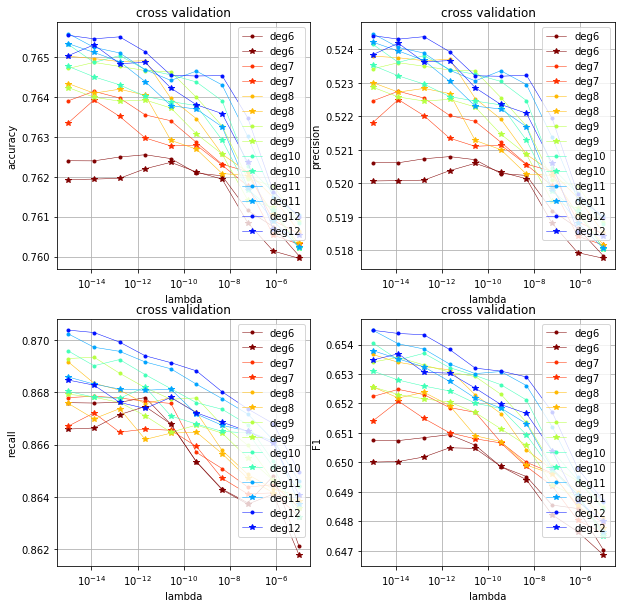

In [157]:
seed = 1
k_fold = 4
lambdas = np.logspace(-15, -5, 10)
degrees = range(6, 13)

k_indices = build_k_indices(y_jet0, k_fold, seed)

rmse_tr_ri, rmse_te_ri, acc_measures = cross_validation_wAcc(y_jet0, tX_jet0, k_indices, k_fold, degrees, 
                                          lambdas , ml_function = 'ri', max_iters = 100, 
                                          gamma = 0.05, verbose = True, interaction=w_interaction)

idx = np.unravel_index(np.nanargmax(acc_measures["acc_te"]), acc_measures["acc_te"].shape)
lambda_ri_jet0 = lambdas[idx[0]]
degree_ri_jet0 = degrees[idx[1]]

print("lambda*={lambda_}\n\ndegree*={degree}\n\nrmse train={rmse_tr}\n\nrmse test={rmse_te}\n\nacc train={acc_tr}\n\nacc test={acc_te}".format(
    lambda_=lambda_ri_jet0, degree=degree_ri_jet0, rmse_tr=rmse_tr_ri[idx], rmse_te=rmse_te_ri[idx],acc_tr=acc_measures["acc_tr"][idx], acc_te=acc_measures["acc_te"][idx]))

vis_cv_acc(degrees,lambdas,acc_measures)

In [ ]:
degree_ri_jet0 = 11
lambda_ri_jet0 = 1e-13
w0_ri, loss0_ri, acc_measures0_ri, data_meas0_ri = build_final_model(y_jet0, tX_jet0, degree_ri_jet0,
                                                      lambda_ri_jet0, ml_function = 'ri', interaction = w_interaction)

print(acc_measures0_ri)

Finished preparing data for cross-validation 

Completed degree 9/9
 Completed lambda 1/10
Completed degree 9/9
 Completed lambda 2/10
Completed degree 9/9
 Completed lambda 3/10
Completed degree 9/9
 Completed lambda 4/10
Completed degree 9/9
 Completed lambda 5/10
Completed degree 9/9
 Completed lambda 6/10
Completed degree 9/9
 Completed lambda 7/10
Completed degree 9/9
 Completed lambda 8/10
Completed degree 9/9
 Completed lambda 9/10
Completed degree 9/9
 Completed lambda 10/10
lambda*=1e-15

degree*=14

rmse train=0.32780962133227115

rmse test=220.29255684616666

acc train=0.7627110629664018

acc test=0.7606649128236872


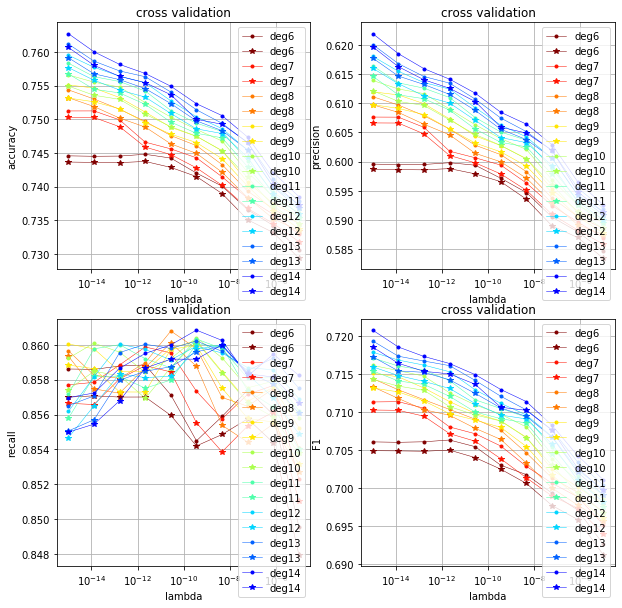

In [158]:
degrees = range(6, 15)
k_indices = build_k_indices(y_jet1, k_fold, seed)

rmse_tr_ri, rmse_te_ri, acc_measures = cross_validation_wAcc(y_jet1, tX_jet1, k_indices, k_fold, degrees, 
                                          lambdas , ml_function = 'ri', max_iters = 100, 
                                          gamma = 0.05, verbose = True, interaction=w_interaction)

idx = np.unravel_index(np.nanargmax(acc_measures["acc_te"]), acc_measures["acc_te"].shape)
lambda_ri_jet1 = lambdas[idx[0]]
degree_ri_jet1 = degrees[idx[1]]

print("lambda*={lambda_}\n\ndegree*={degree}\n\nrmse train={rmse_tr}\n\nrmse test={rmse_te}\n\nacc train={acc_tr}\n\nacc test={acc_te}".format(
    lambda_=lambda_ri_jet1, degree=degree_ri_jet1, rmse_tr=rmse_tr_ri[idx], rmse_te=rmse_te_ri[idx],acc_tr=acc_measures["acc_tr"][idx], acc_te=acc_measures["acc_te"][idx]))

vis_cv_acc(degrees,lambdas,acc_measures)

In [ ]:
# As there is a huge drop in recall for lambas smaller then 1e-12, we chose to change the lambda_ri_jet1 to 1e-12
# and degree 12 to avoid overfitting
lambda_ri_jet1 = 1e-12
degree_ri_jet1 = 14
w1_ri, loss1_ri, acc_measures1_ri, data_meas1_ri = build_final_model(y_jet1, tX_jet1, degree_ri_jet1,
                                                      lambda_ri_jet1, ml_function = 'ri', interaction = w_interaction)

print(acc_measures1_ri)

Finished preparing data for cross-validation 

Completed degree 9/9
 Completed lambda 1/10
Completed degree 9/9
 Completed lambda 2/10
Completed degree 9/9
 Completed lambda 3/10
Completed degree 9/9
 Completed lambda 4/10
Completed degree 9/9
 Completed lambda 5/10
Completed degree 9/9
 Completed lambda 6/10
Completed degree 9/9
 Completed lambda 7/10
Completed degree 9/9
 Completed lambda 8/10
Completed degree 9/9
 Completed lambda 9/10
Completed degree 9/9
 Completed lambda 10/10
lambda*=1e-15

degree*=11

rmse train=0.26634390987484463

rmse test=517.0540193769405

acc train=0.8236007719878687

acc test=0.8211607389026744


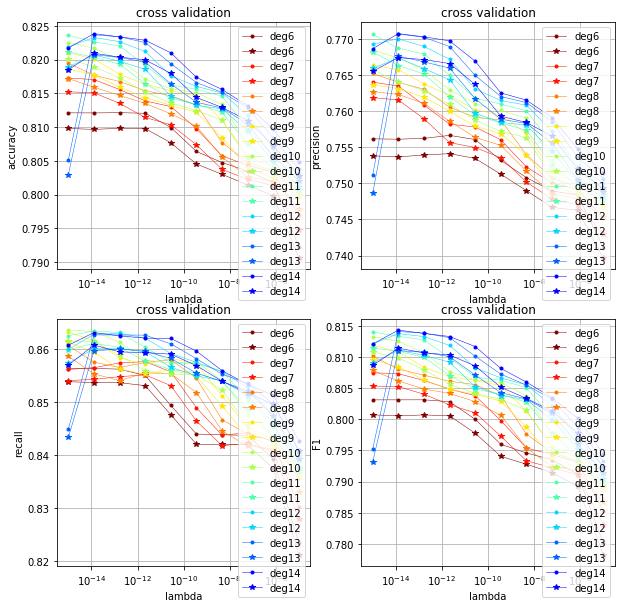

In [159]:
k_indices = build_k_indices(y_jet2, k_fold, seed)

rmse_tr_ri, rmse_te_ri, acc_measures = cross_validation_wAcc(y_jet2, tX_jet2, k_indices, k_fold, degrees, 
                                          lambdas , ml_function = 'ri', max_iters = 100, 
                                          gamma = 0.05, verbose = True, interaction=w_interaction)

idx = np.unravel_index(np.nanargmax(acc_measures["acc_te"]), acc_measures["acc_te"].shape)
lambda_ri_jet2 = lambdas[idx[0]]
degree_ri_jet2 = degrees[idx[1]]

print("lambda*={lambda_}\n\ndegree*={degree}\n\nrmse train={rmse_tr}\n\nrmse test={rmse_te}\n\nacc train={acc_tr}\n\nacc test={acc_te}".format(
    lambda_=lambda_ri_jet2, degree=degree_ri_jet2, rmse_tr=rmse_tr_ri[idx], rmse_te=rmse_te_ri[idx],acc_tr=acc_measures["acc_tr"][idx], acc_te=acc_measures["acc_te"][idx]))

vis_cv_acc(degrees,lambdas,acc_measures)

In [ ]:
# As there is a drop in recall for lambas smaller then 1e-12, we chose to change the lambda_ri_jet1 to 1e-12
# and degree 11 to avoid overfitting
lambda_ri_jet2 = 1e-13
degree_ri_jet2 = 11
w2_ri, loss2_ri, acc_measures2_ri, data_meas2_ri = build_final_model(y_jet2, tX_jet2, degree_ri_jet2,
                                                      lambda_ri_jet2, ml_function = 'ri', interaction = w_interaction)

print(acc_measures2_ri)

## Logistic regression

### Full dataset

In [27]:
ltX = build_poly_inter(tX.copy(), 1, interaction = w_interaction)
ltX, _, _ = standardize_train(ltX)

In [28]:
yl = np.where(y==-1, 0, y)
max_iters = 1000
gammas = np.logspace(-10, -1, 20)
initial_w = np.zeros(ltX.shape[1])

In [ ]:
losses_lr = np.empty(len(gammas))
ws_lr = np.empty((len(gammas), len(initial_w)))
for idx, gamma in enumerate(gammas):
    (w, loss) = logistic_regression(yl, ltX, initial_w, max_iters, gamma)
    losses_lr[idx] = loss
    ws_lr[idx, :] = w

In [ ]:
#plot the losses per gamma used
fig, ax = plt.subplots()
ax.semilogx(gammas, losses_lr)

ax.set(xlabel='gamma', ylabel='loglikelihood',
       title='Log likelihood per choice of learning rate')
ax.grid()
plt.show()

In [ ]:
idx = np.nanargmin(losses_lr)

w_lr = ws_lr[idx]
gamma_lr = gammas[idx]

print("w* ={w}\n\nloglikelihood loss={loss}\n\ngamma={gamma}".format(
    w=w_lr, loss=losses_lr[idx], gamma = gamma_lr))

#### Cross-validation for hyperparameter determination

In [ ]:
seed = 1
k_fold = 4
degrees = range(1, 9)

k_indices = build_k_indices(y, k_fold, seed)

loss_tr_lr, loss_te_lr, acc_measures_lr = cross_validation_wAcc(yl, tX, k_indices, k_fold, degrees, lambdas = [0],
                                                                 ml_function = 'lr', max_iters = 1000, gamma = gamma_lr,
                                                                 verbose = True, interaction = w_interaction)

In [ ]:
vis_cv_acc(degrees,lambdas,acc_measures_lr)

In [ ]:
loss_te_lr = np.array(loss_te_lr)
loss_tr_lr = np.array(loss_tr_lr)

idx = np.nanargmax(acc_measures_lr["acc_te"])

degree_lr = degrees[idx]

print("degree*={degree}\n\nloglikelihood train={loss_tr}\n\nloglikelihood test={loss_te}\n\nacc train={acc_tr}\n\nacc test={acc_te}".format(
    degree=degree_lr, loss_tr=loss_tr_lr.flatten()[idx], loss_te=loss_te_lr.flatten()[idx],
    acc_tr=acc_measures_lr["acc_tr"].flatten()[idx], acc_te=acc_measures_lr["acc_te"].flatten()[idx]))

## Regularized logistic regression

### Full dataset

#### Cross-validation hyperparameter selection

In [ ]:
seed = 1
degree_rlr = 1
k_fold = 4
lambdas = np.logspace(-8, -2, 5)
degrees = range(1, 5)

k_indices = build_k_indices(yl, k_fold, seed)

In [ ]:
loss_tr_rlr, loss_te_rlr, acc_measures_rlr = cross_validation_wAcc(yl, tX, k_indices, k_fold, degrees,
                                                                   lambdas, ml_function = 'rlr', max_iters = 500,
                                                                   gamma = gamma_lr, verbose = True,
                                                                   interaction = w_interaction)

In [ ]:
vis_cv_acc(degrees,lambdas, acc_measures_rlr)

In [ ]:
idx = np.unravel_index(np.nanargmax(acc_measures_rlr["acc_te"]), acc_measures_rlr["acc_te"].shape)
lambda_rlr = lambdas[idx[0]]
degree_rlr = degrees[idx[1]]

print("degree*={degree}\n\nloglikelihood train={loss_tr}\n\nloglikelihood test={loss_te}\n\nacc train={acc_tr}\n\nacc test={acc_te}".format(
    degree=degree_rlr, loss_tr=loss_tr_rlr[idx], loss_te=loss_te_rlr[idx],
    acc_tr=acc_measures_rlr["acc_tr"][idx], acc_te=acc_measures_rlr["acc_te"][idx]))

# Generate predictions and save ouput in csv format for submission:

In [136]:
DATA_TEST_PATH = '../data/test.csv'
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

tX_test = log_transformation(tX_test)
print(tX_test.shape)

(568238, 30)


##### Full dataset

In [ ]:
y_pred = make_prediction(tx=tX_test.copy(), weights = w_ri.copy(), rmx = rmX.copy(), median = mtX.copy(),
                          d=degree_ri, train_data_measures=data_meas_ri, 
                         interactions = w_interaction, ml_function = "ri")

In [ ]:
OUTPUT_PATH = '../data/submission_full.csv'
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

##### Jet sub-datasets

In [138]:
%whos

Variable                                    Type        Data/Info
-----------------------------------------------------------------
DATA_TEST_PATH                              str         ../data/test.csv
DATA_TRAIN_PATH                             str         ../data/train.csv
OUTPUT_PATH                                 str         ../data/submission_jets.csv
acc_measures                                dict        n=8
acc_measures0_ri                            dict        n=4
acc_measures1_ri                            dict        n=4
acc_measures2_ri                            dict        n=4
acc_measures_ri                             dict        n=4
batch_iter                                  function    <function batch_iter at 0x000000007149BEE8>
bias_variance_decomposition_visualization   function    <function bias_variance_d<...>on at 0x000000007149A288>
build_final_model                           function    <function build_final_mod<...>el at 0x000000007149A438>
build_interac

In [139]:
y_test = np.zeros(tX_test.shape[0])
idx_test0, y_test0, tX_test0, idx_test1, y_test1, tX_test1, idx_test2, y_test2, tX_test2 = separate_jet(y_test, tX_test)

print(tX_test0.shape[0]+tX_test1.shape[0]+tX_test2.shape[0])

568238


In [140]:
y_test0 = make_prediction(tX_test0, w0_ri, rmX_jet0, median_jet0,
                          degree_ri_jet0, data_meas0_ri, interactions = w_interaction, ml_function = "ri")

Deleting features...done
Imputing missing data...done
Building data matrix...done
Standardizing data matrix...done
Making predictions...done


In [141]:
y_test1 = make_prediction(tX_test1, w1_ri, rmX_jet1, median_jet1,
                          degree_ri_jet1, data_meas1_ri, interactions = w_interaction, ml_function = "ri")

Deleting features...done
Imputing missing data...done
Building data matrix...done
Standardizing data matrix...done
Making predictions...done


In [142]:
y_test2 = make_prediction(tX_test2, w2_ri, rmX_jet2, median_jet2,
                          degree_ri_jet2, data_meas2_ri, interactions = w_interaction, ml_function = "ri")

Deleting features...done
Imputing missing data...done
Building data matrix...done
Standardizing data matrix...done
Making predictions...done


In [143]:
print(w0_ri.shape, w1_ri.shape, w2_ri.shape)

(235,) (287,) (349,)


In [144]:
OUTPUT_PATH = '../data/submission_jets_noLog_noInteraction.csv'
y_pred = merge_jet(idx_test0, y_test0, idx_test1, y_test1, idx_test2, y_test2)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

In [145]:
print(y_pred.shape)

(568238,)
